In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.constants as const
import astropy.units as u
from astropy.coordinates import SkyCoord
import healpy as hp
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools

#### GOAL:

Compute the expected dipole from Ellis & Baldwin (1984) in Quaia in different redshift bins.

#### functions

In [3]:
def Vega_to_AB(BR_Vega, offset=-0.3250):  # offset computed from Gaia photometric zero points
                                    # (Tables 5.2-5.3 in https://gea.esac.esa.int/archive/documentation/GDR2/ \
                                    # Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_calibr_extern.html )
    return BR_Vega + offset

In [4]:
def compute_alpha(B, R, lambda_B=505.15, lambda_R=772.62):
    """
    Compute the spectral slope alpha for a source with given BP and RP magnitudes.
    PARAMETERS:
    - B = BP magnitude (Vega system)
    - R = RP magnitude (Vega system)
    - lambda_B = wavelength (nm) of blue passband (default is the "pivot wavelength" given by Gaia)
    - lambda_R = wavelength (nm) of red passband (")
    """
    # convert given (B-R)_Vega to AB color (B-R)_AB
    BR_AB = Vega_to_AB(B-R)
    
    alpha = BR_AB/(2.5*np.log10(lambda_R/lambda_B))

    return alpha

In [21]:
def compute_alphas(qso_table, target=20.4):
    # enforce magnitude limit
    qsos = qso_table[qso_table['phot_g_mean_mag'] <= target]
    return [
        compute_alpha(qsos['phot_bp_mean_mag'][i], qsos['phot_rp_mean_mag'][i]) \
        for i in range(len(qsos))
    ]

In [18]:
def compute_x(qso_table, target=20.4, ming=18, binwidth=0.1):
    maxg = target + binwidth
    nmags = int((maxg-ming)/binwidth)+1
    mags = np.linspace(ming, maxg, nmags)
    counts = np.array([
        np.sum(qso_table['phot_g_mean_mag'] <= mag) for mag in mags
    ])
    dlogN = np.log10(counts[-1])-np.log10(counts[-3])
    dmags = mags[-1]-mags[-3]
    return 2.5*(dlogN)/dmags, mags, counts

In [17]:
def EllisBaldwin(x, alpha, v=369.825*u.km/u.s):
    """
    Returns the expected dipole amplitude from Ellis & Baldwin (1984), given
        x = number-count slope at flux density limit
        alpha = source spectral index assuming power law spectra
    """
    return v / const.c.to(u.km/u.s) * (2 + x * (1+alpha))

In [19]:
def dipole_estimate(quaia_table, zlim, target=20.4, prints=True, plots=True, bins=120):
    
    zs = quaia_table['redshift_quaia']
    gs = quaia_table['phot_g_mean_mag']
    
    # isolate redshift range
    qsos = quaia_table[(zs >= zlim[0]) & (zs <= zlim[1])]
    
    """ALPHA"""
    alphas = compute_alphas(qsos, target)
    alpha = np.mean(alphas)
    
    """X"""
    x, mags, counts = compute_x(qsos, target)
    
    if prints:
        print(f"for {zlim[0]:.2f} <= z <= {zlim[1]:.2f}: ({len(qsos)} sources): \n mean alpha = {alpha:.4f} \n x = {x:.4f}")
    
    if plots:
        
        fig, ax = plt.subplots()
        _, _, _ = ax.hist(qsos['redshift_quaia'], bins=bins, alpha=0.8)
        ax.set_xlabel('Redshift')
        ax.set_ylabel('Sources')
        ax.set_title('Redshift distribution')
        
        fig, ax = plt.subplots()
        _, _, _ = ax.hist(alphas, bins=bins, alpha=0.8)
        ax.set_yscale('log')
        ax.set_xlabel(r'$\alpha$')
        ax.set_ylabel('Sources')
        ax.set_title(f'Alpha (spectral slope) distribution')
    
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(mags, counts, 'k.-', lw=0.5)
        ax.axvline(target, color='k', alpha=0.3, ls='--', lw=0.5)
        ax.plot(mags[-1], counts[-1], marker='x', color='r')
        ax.plot(mags[-3], counts[-3], marker='x', color='r')
        ax.set_yscale('log')
        ax.set_xlabel('G')
        ax.set_ylabel('N < G')
        ax.set_title('Quaia G number counts')
    
    return EllisBaldwin(x, alpha)

In [10]:
# load Quaia
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
G = 20.5
cat_fn = f'/scratch/aew492/quasars/catalogs/quaia_G{G}.fits'
tab_quaia = Table.read(cat_fn, format='fits')

for 0.00 <= z <= 1.00: (327276 sources): 
 mean alpha = 0.8294 
 x = 0.9738


<Quantity 0.00466487>

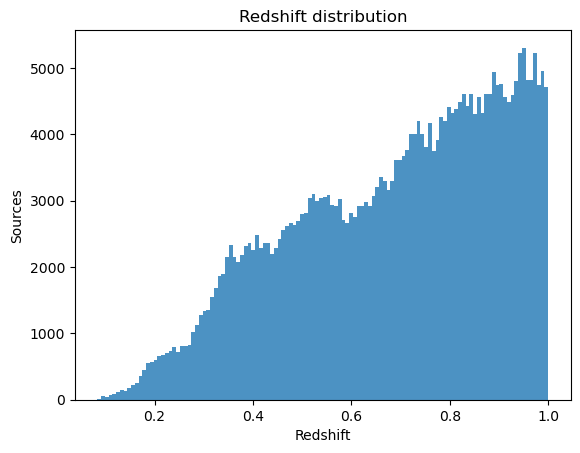

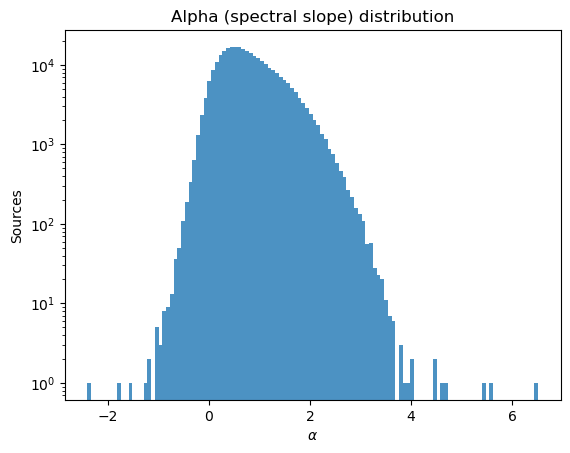

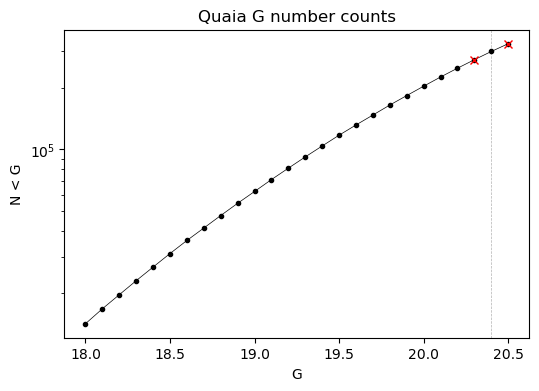

In [22]:
dipole_estimate(tab_quaia, (0,1))

for 1.00 <= z <= 2.00: (648226 sources): 
 mean alpha = 0.7461 
 x = 1.1577


<Quantity 0.00496078>

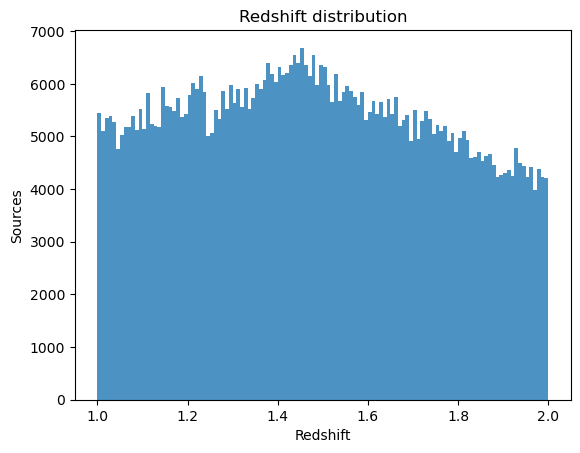

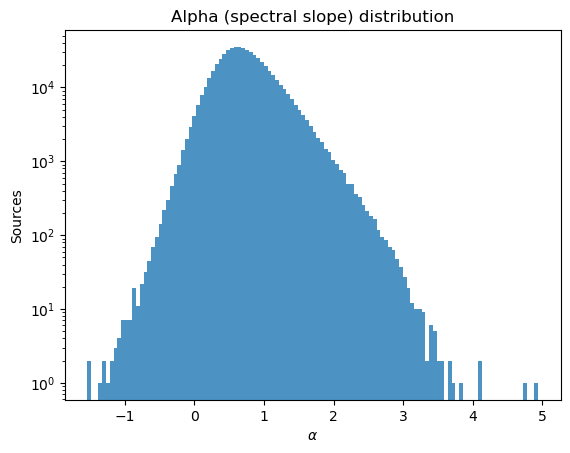

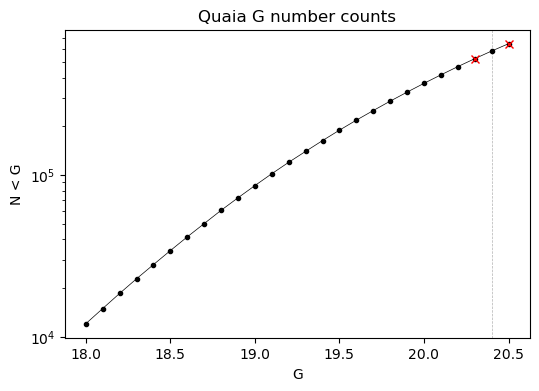

In [23]:
dipole_estimate(tab_quaia, (1,2))

for 2.00 <= z <= 3.00: (283967 sources): 
 mean alpha = 0.7137 
 x = 1.0862


<Quantity 0.00476352>

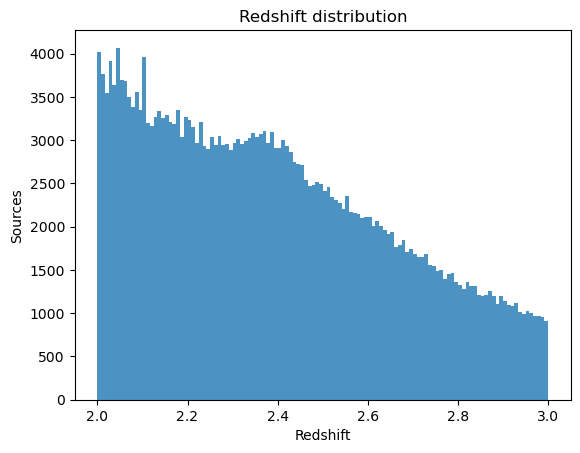

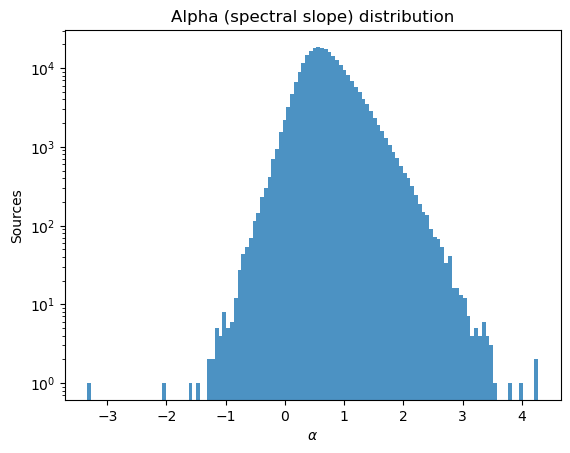

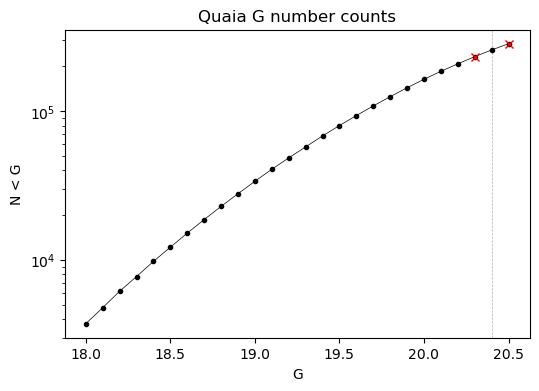

In [24]:
dipole_estimate(tab_quaia, (2,3))

for 3.00 <= z <= 4.00: (35466 sources): 
 mean alpha = 1.1624 
 x = 1.0686


<Quantity 0.00531775>

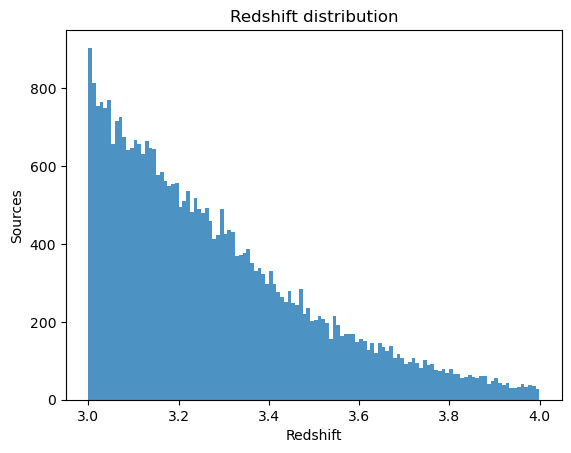

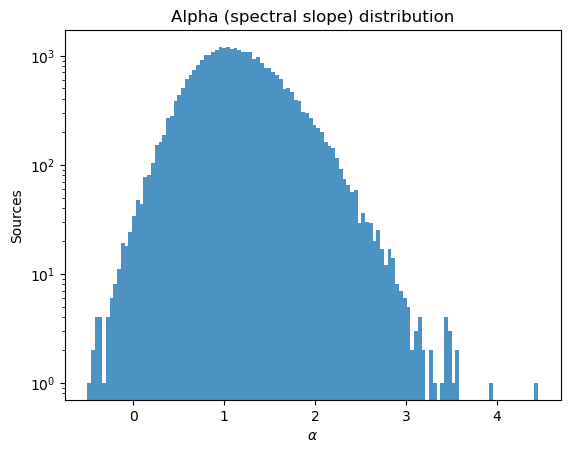

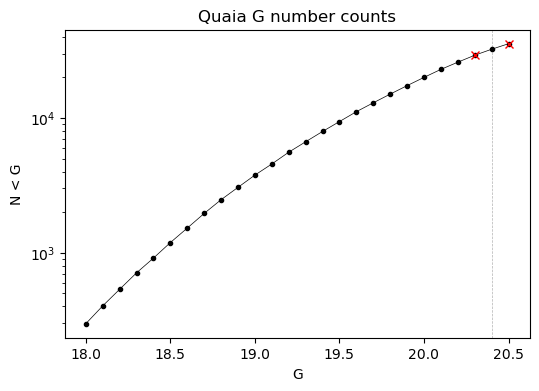

In [25]:
dipole_estimate(tab_quaia, (3,4))